# 03 Modelling

**Objective of this notebook is to generate a linear regression model using the selected nominal features only.
The steps and parameters will remain the same as the full regression model that is trained on numeric, ordinal, and nominal features.**

### Import Libraries

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression,  Ridge

from sklearn.metrics import mean_squared_error

In [9]:
# apply a plot style
plt.style.use('bmh')

### Read The Datasets

In [10]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [11]:
print(train.shape)
print(test.shape)

(1538, 82)
(513, 81)


### Preprocessing Data

- apply preprocessing() to train dataframe to clean the data
- trim down the dataframe to only contain selected nominal features

In [12]:
#trim down the data columns to only the numeric features:
nominal_features = ['Neighborhood', 'MS Zoning', 'Bldg Type', 'Mas Vnr Type', 'House Style', 'Foundation','Sale Type']

In [13]:
def preprocessing(df):
    ''' This function takes in a dataframe containing the Ames Housing dataset and preprocess it for regression models.'''

    #There are 2 outliers identified in EDA based on scatterplot of 'Gr Liv Area' vs. "SalePrice".
    #Drop these outliers
    drop_rows_GrLivArea_outliers = df[(df['Gr Liv Area'] > 4000)].index
    df = df.drop(drop_rows_GrLivArea_outliers, axis =0)
        
    #NUMERIC DATA TYPES
    # Creating 'porch_deck_sqft' by summing all porch and deck square footage columns
    porch_and_deck_features = ['Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch', '3Ssn Porch']
    df['porch_deck_sqft'] = df[porch_and_deck_features].sum(axis=1)
    
    # Creating 'all_baths_count' by summing all types of bathrooms
    bath_features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'Full Bath']
    df['all_baths_count'] = df[bath_features].sum(axis=1)
    
    # fill in missing values in the following numeric features with 0
    df['Total Bsmt SF'].fillna(0, inplace = True)
    df['Mas Vnr Area'].fillna(0, inplace = True)
    df['Garage Cars'].fillna(0, inplace = True)
    df['Garage Area'].fillna(0, inplace = True)
    
    
    #go through the dataframe, and if there is a missing value in "Lot Frontage", fill in with the mean of "Lot Frontage" that is groupby "Neighborhood"
    df['Lot Frontage'] = df.groupby("Neighborhood")['Lot Frontage'].transform(lambda value : value.fillna(value.mean()))
    #if there are still NaN values, just drop the row:
    df.dropna(subset=['Lot Frontage'], inplace=True)   
    
    #STRING OBJECT DATA TYPES
    # fill in NaNs in "Mas Vnr Type", which records the masonry veneer type (nominal), and one of the options is "None".
    df['Mas Vnr Type'].fillna('None', inplace = True)
    
    # Fill in the NaNs in categorical garage features with "No Garage"
    df['Garage Qual'].fillna('NA', inplace = True)
    
    # Fill in the NaNs in categorical ordinal "Bsmt Qual" features with "No Garage"
    df["Bsmt Qual"].fillna('NA', inplace = True)

    return df

In [14]:
train_preprocessed = preprocessing(train)
train_trimmed_nominal = train_preprocessed[nominal_features + ['SalePrice']]
train_trimmed_nominal.head()

,Neighborhood,MS Zoning,Bldg Type,Mas Vnr Type,House Style,Foundation,Sale Type,SalePrice
0,NAmes,RL,1Fam,BrkFace,1Story,CBlock,WD,167300
1,Sawyer,RL,1Fam,None,2Story,CBlock,WD,219000
2,NAmes,RL,1Fam,None,1Story,CBlock,WD,129000
3,ClearCr,RL,1Fam,None,2Story,PConc,WD,328000
4,NoRidge,RL,1Fam,BrkFace,2Story,PConc,WD,290000


In [15]:
# double check if there are any nulls left:
train_trimmed_nominal.isnull().sum()

Neighborhood    0
MS Zoning       0
Bldg Type       0
Mas Vnr Type    0
House Style     0
Foundation      0
Sale Type       0
SalePrice       0
dtype: int64

### Feature Engineering

In [16]:
#separate the train set data into X features and y target
X = train_trimmed_nominal.drop('SalePrice', axis =1)
y = train_trimmed_nominal['SalePrice']

In [17]:
# split up X and y into train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [18]:
# verify that the shapes are ok
print(X_train.shape)
print(y_train.shape)

(1149, 7)
(1149,)


### Transformer and Pipeline

In [20]:
# encode nominal_features using OneHotEncoder
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# use ColumnTransformer to transform each feature based on the type (numeric, nominal, or ordinal)
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_features)])

### TransformTargetRegressor and Pipeline

In [21]:
# our function is log
# our inverse function is np.exp
ttr_ridge_model = TransformedTargetRegressor(Ridge(), func = np.log, inverse_func = np.exp)

In [22]:
# Combine into a complete pipeline
ridge_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ('ttr_ridge_model', ttr_ridge_model)])

In [23]:
ridge_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Neighborhood', 'MS Zoning',
                                                   'Bldg Type', 'Mas Vnr Type',
                                                   'House Style', 'Foundation',
                                                   'Sale Type'])])),
                ('ttr_ridge_model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

### Hyperparameter tuning with GridSearchCV

In [24]:
# Using GridSearchCV for hyperparameter tuning
#params for ridge & polynomialfeatures
param_grid = {
    'ttr_ridge_model__regressor__alpha': [0.1, 1, 10]}

gridsearchcv = GridSearchCV(estimator=ridge_pipe,
                            param_grid=param_grid,
                            cv=5,
                            scoring='r2',
                            error_score='raise',
                            verbose=1)

In [25]:
#fit gridsearchcv to train set:
gridsearchcv.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('nominal',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Neighborhood',
                                                                          'MS '
                                                                          'Zoning',
                                                                          'Bldg '
                                                                          'Type',
                                                                          'Mas '
                                                                          'Vnr '
                                                                          'Type',
                                                                          'House '
                                                                          'Style',
                                                                          'Foundation',
                                                                          'Sale '
                                                                          'Type'])])),
                                       ('ttr_ridge_model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=Ridge()))]),
             param_grid={'ttr_ridge_model__regressor__alpha': [0.1, 1, 10]},
             scoring='r2', verbose=1)

### check model parameters & evaluate model

In [26]:
# use the grid_model to make predictions using X_test_scaled
# note that this is still a subset of train.csv and not the test.csv
y_predictions_nominal = gridsearchcv.predict(X_test)
# y_predictions

In [28]:
print("Best parameters:", gridsearchcv.best_params_)
print("Best R^2 score:", gridsearchcv.best_score_)

Best parameters: {'ttr_ridge_model__regressor__alpha': 1}
Best R^2 score: 0.650266386796793


In [29]:
# RMSE and average SalePrice
print('RMSE:', np.sqrt(mean_squared_error(y_test,y_predictions_nominal)))
print('Average SalePrice:', np.mean(train['SalePrice']))

RMSE: 44255.62945106301
Average SalePrice: 181061.9934980494


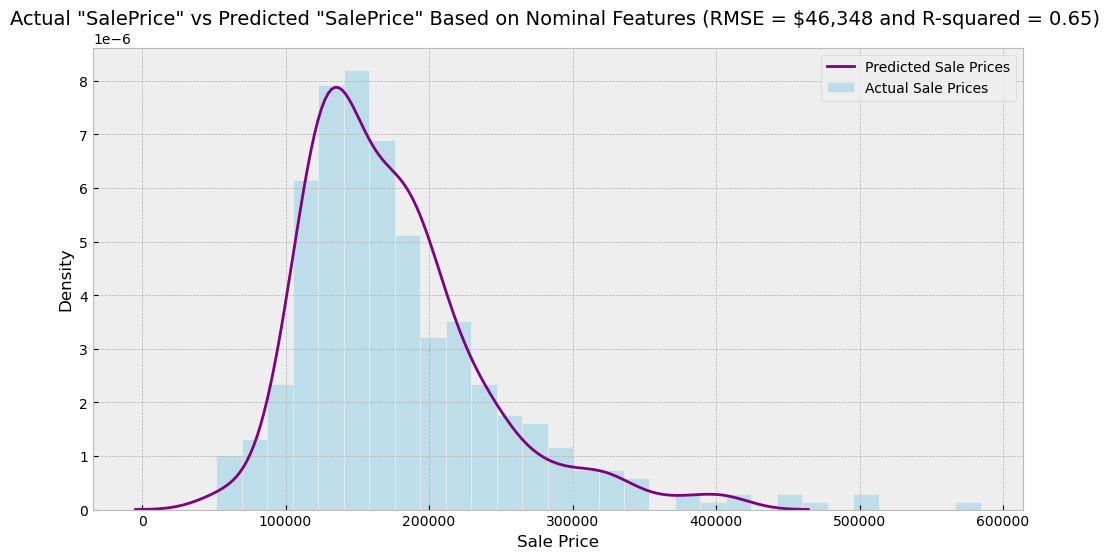

In [31]:
# Create a histogram of the actual sale prices
plt.figure(figsize=(12,6))
sns.histplot(y_test, bins=30, kde=False, color='lightblue', label='Actual Sale Prices', stat="density")

# Plot the predicted sale prices as a density plot (smooth curve)
sns.kdeplot(y_predictions_nominal, color='purple', label='Predicted Sale Prices')

# Adding labels and legend
plt.xlabel('Sale Price')
plt.ylabel('Density')
plt.title('Actual "SalePrice" vs Predicted "SalePrice" Based on Nominal Features (RMSE = $46,348 and R-squared = 0.65) ', fontsize = 14)
plt.legend()
plt.savefig('../images/Actual_salePrice_vs_Prediction_Nominal_Features.png', dpi=300)
plt.show()
